<a href="https://colab.research.google.com/github/yustiks/statistics_in_python/blob/master/statistics_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 4. Кейс-стади. Статистические показатели.

Соревнования с kaggle: Titanic challenge. 

Данные разделены на 2 файла: 


*   тренировочные данные ('train.csv')
*   тестовые данные ('test.csv')

Тренировочные данные нужны для построения модели. Для тренировочных данных есть показатель класса для каждого пассажира. Модель будет базироваться на таких значениях как пол пассажира и класс. 

Тестовые данные нужны чтобы посмотреть насколько хорошо модель обучена на тренировочных данных. Для тестовых данных нет показателя класса. Вам необходимо найти класс для каждого пассажира. 

Есть также файл 'gender_submission.csv' как показательный файл того, что нужно загружать в качестве ответа.

Считываем данные с kaggle

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
%matplotlib inline

In [0]:
url='http://yustiks.ru/titanic/train.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Итак, есть такие данные, как:


*   PassengerId - id пассажира
*   Survived - выжил или нет (1 - да, 0 - нет)
*   Pclass - класс билеты (1 = 1ый, 2 = 2ой, 3 = 3ий)
*   Namee - имя 
*   Sex - пол 
*   Age - возраст
*   SibSp - количество родных или муж/жена на корабле
*   Parch - количество родителей/детей на корабле
*   Ticket - номер билета
*   Cabin - наименование кабины (NaN - если неизвестно)
*   Embarked - порт отправления (C = Cherbourg, Q = Queenstown, S = Southampton).

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Начертим график плотности распределения величин. 

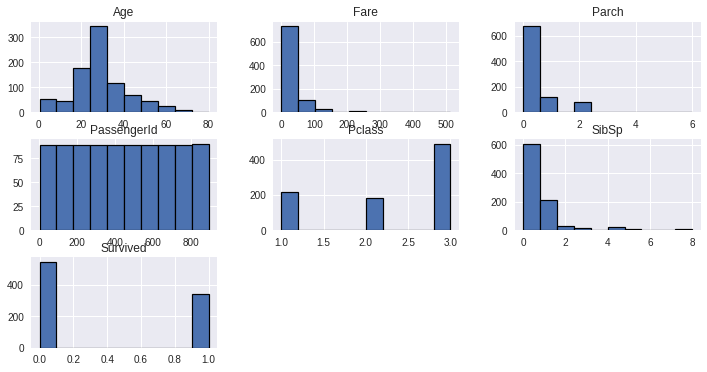

In [0]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

На графике плотностей распределения четко видны такие распределения, как 


*   Биноминальное распределение ('Survived')
*   Равномерное распределение ('PassengerId')
*   Нормальное ('Age')
*   Логнормальное ('SibSp', 'Fare')


Посмотрим отсутствующие данные:

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


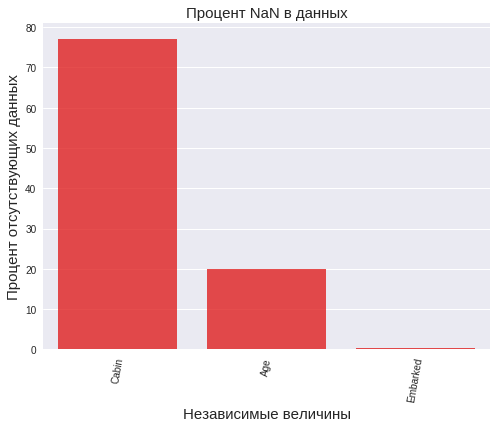

In [0]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

missingdata(data)

У нас есть также тестовые данные. Давайте посмотрим, отсутствуют ли в тестовых данных те же самые величины. 

In [0]:
url='http://yustiks.ru/titanic/test.csv'
s=requests.get(url).content
test=pd.read_csv(io.StringIO(s.decode('utf-8')))
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


Как можно заметить в тестовых данных нет класса Survived. 

Посмотрим процент отсутствующих данных:

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


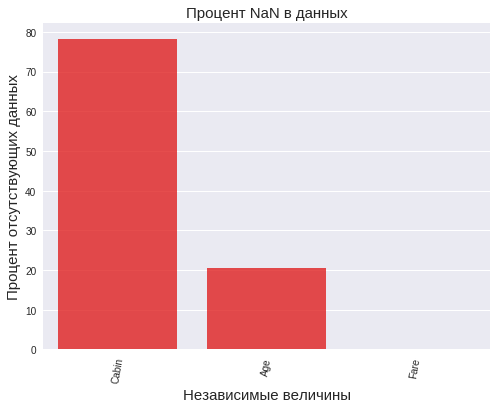

In [0]:
missingdata(test)

График очень похож на тренировочные данные, поэтому нужно придумать алгоритм, который поможет избавиться от выбросов. 

Во-первых, посмотрим график встречаемости переменной 'Age':

Text(0.5, 1.0, 'Оценка переменной')

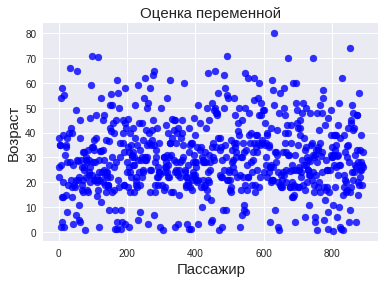

In [0]:
fig=plt.scatter(data.index, data["Age"],color="blue",alpha=0.8)
plt.xlabel('Пассажир', fontsize=15)
plt.ylabel('Возраст', fontsize=15)
plt.title('Оценка переменной', fontsize=15)

Как вариант, можно заполнить неизвестные данные по правилу медианного фильтра: вместо Nan можно использовать среднее значение (не всегда работает). 

In [0]:
test['Age'].fillna(test['Age'].median(), inplace = True)
data['Age'].fillna(data['Age'].median(), inplace = True)

То же самое делаем со значением Fare 

In [0]:
test['Fare'].fillna(test['Fare'].median(), inplace = True)

Нам не нужны значения 'Cabin', так как это просто номер кабины - удаляем колонку

In [0]:
drop_column = ['Cabin']
data.drop(drop_column, axis=1, inplace = True)
test.drop(drop_column,axis=1,inplace=True)

Значение Embarked есть отсутствующие значения в таблице тренировочных данных, но нет в тестовых, поэтому в случае с тестовыми данными мы можем например использовать наиболее встречаемое значение в качестве заполнения неизвестных (так называемую **моду** - значение признака, имеющее наибольшую частоту в статистическом ряду распределения)

In [0]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

Проверим, имеются ли отсутствующие значения в данных

In [0]:
print(data.isnull().sum())
print(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Можно сказать, успешно избавились от выбросов путем заполнения данных с помощью :


*   медианы
*   моды



Объединим теперь данные в один вектор для дальнейших действий

In [0]:
all_data=[data,test]

Наверное, нам не нужны имена, но мы можем использовать такие данные, как Miss, Mister, Mademoiselle (эти данные могут говорить о происхождение человека - англичане), поэтому имеет смысл из имен вычленить только значения Miss, 

In [0]:
import re
# Библиотека re - для применения регулярных выражений
# Let us then extract second word from every row and assign it to a new column. Not only that let us make it categorical (so that we can one-hot encode it) where we observe the most frequent ones.


def title_parser(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Проверяем если значение есть, то возвращаем его, если нет, то возвращаем ''
    if title_search:
        return title_search.group(1)
    return ""
# Создаем новую колонку 'Title' для титула
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(title_parser)
# Если встречаются непонятные титулы, называем их irrelevant
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'irrelevant')
# Некоторые значения также означают Miss - Mlle, Ms, а вот Mme (Madame) означает Mrs
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Тренировочные данные

In [0]:
all_data[0][:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [0]:
Тестовые данные

In [0]:
all_data[1][:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


Можно увидеть, что вместе с массивом all_data поменялись значения в массиве data и test - добавилась колонка Title

In [0]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [0]:
test[:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


Посмотрим как значения взаимодействуют друг с другом на графике с разбивкой на классы:

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


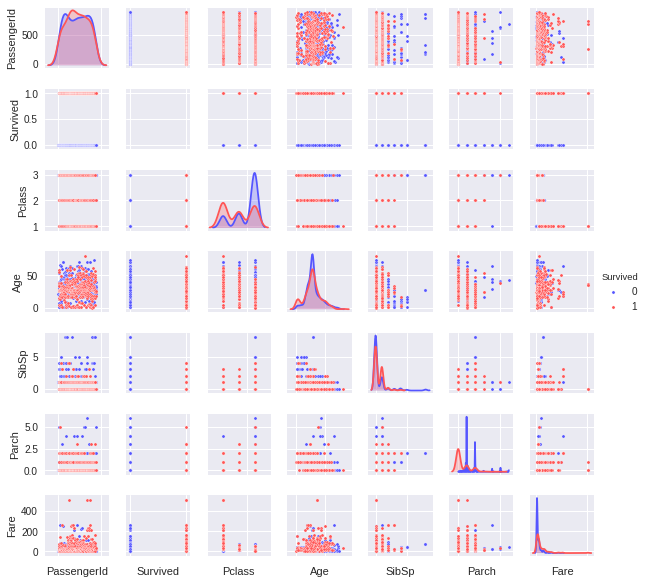

In [0]:
g = sns.pairplot(data=data, hue='Survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

На основе имеющихся значений мы можем создать новые: 

In [0]:
# Создаем новое значение FamilySize как комбинацию SibSp и Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    ## создаем Age_bin для значения age 
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

# Создадим класс для fare 
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

Теперь появились новые колонки, которые также могут нести какой-то смысл (не всегда работает)

In [0]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,Adult,high_fare


Мы можем удалить такие значения как Name и Ticket, так как из Name мы создали категорированные данные (Miss, Mister, Mrs),  а номер билета все равно ни о чем не говорит, поэтому удаляем эти колонки

In [0]:
for dataset in all_data:
    drop_column = ['Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

Проверяем: колонок стало меньше

In [0]:
data[:4]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,Adult,high_fare


Так как у нас получилось много данных категорийных, мы можем заменить эти колонки на вектора (one-hot encoding), таким образом легче для сравнения этих значений

In [0]:
# Пример pd.dummies 
# s = pd.Series(list('abca'))
# pd.get_dummies(s)
#    a  b  c
# 0  1  0  0
# 1  0  1  0
# 2  0  0  1
# 3  1  0  0
data_new = pd.get_dummies(data, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

test_new = pd.get_dummies(test, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

data_new.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_irrelevant', 'Age_type_Children',
       'Age_type_Teenage', 'Age_type_Adult', 'Age_type_Elder', 'Em_type_C',
       'Em_type_Q', 'Em_type_S', 'Fare_type_Low_fare', 'Fare_type_median_fare',
       'Fare_type_Average_fare', 'Fare_type_high_fare'],
      dtype='object')

Получилось довольно много переменных, но насколько эти переменные имеют значение? Некоторые переменные можно исключить, так как они не несут никакой информации (сильно кореллированы с другими переменными). Нарисуем матрицу теплоты для того, чтобы показать корелляцию между переменными. Значение корелляции Пирсона в ячейках матрицы говорит о величине корелляции

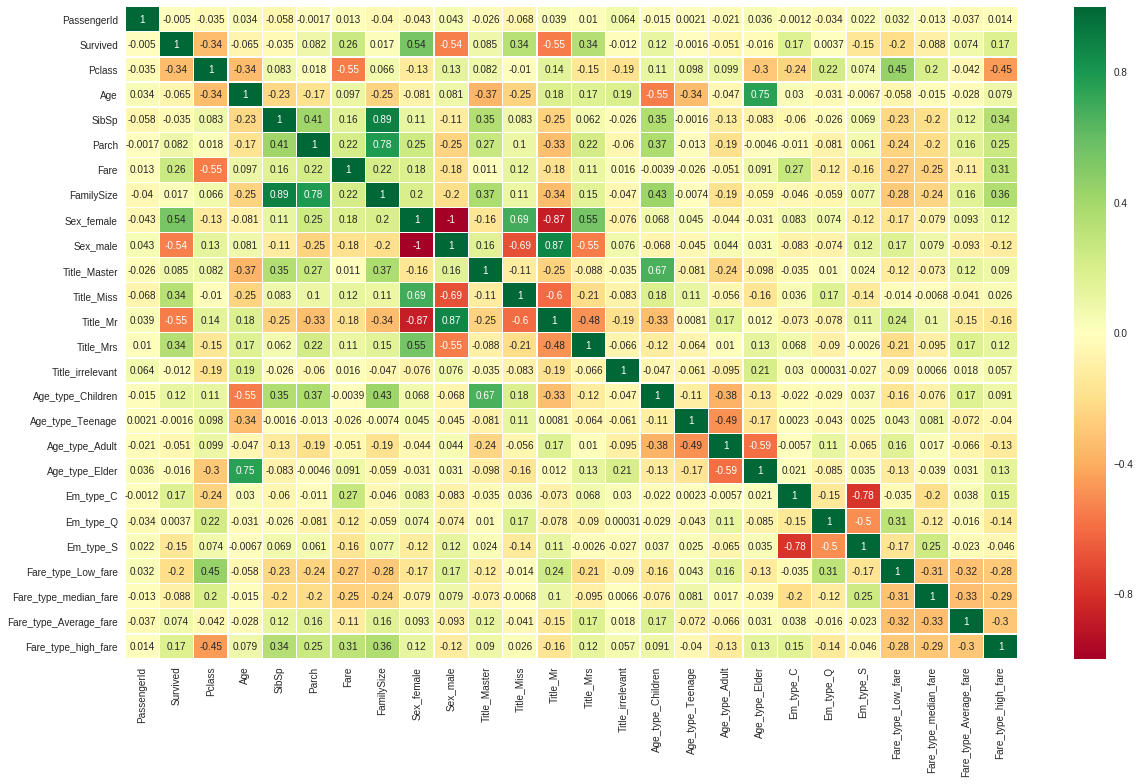

In [0]:
sns.heatmap(data_new.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Можно например объединить такие переменные, которые имеют корелляцию больше чем 70% (красные и зеленые ячейки)

In [0]:
corr_matrix = data_new.corr().abs()

# выбирается верхний треугольник матрицы корелляций (она же симметрична)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# найдем индексы колонок с корелляцией больше чем 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)

['FamilySize', 'Sex_male', 'Title_Mr', 'Age_type_Elder', 'Em_type_S']


In [0]:
data_new = data_new.drop(data_new[to_drop], axis=1)
test_new = test_new.drop(test_new[to_drop], axis=1)

In [0]:
data_new[:2]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Title_Master,Title_Miss,...,Title_irrelevant,Age_type_Children,Age_type_Teenage,Age_type_Adult,Em_type_C,Em_type_Q,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,1,0,3,22.0,1,0,7.2500,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,0,...,0,0,0,1,1,0,0,0,0,1


Нормирование числовых данных

In [0]:
from sklearn.preprocessing import MinMaxScaler

# конвертируем данные Series в Numeric
data_new[['Age','Fare']] = data_new[['Age',"Fare"]].apply(pd.to_numeric)
test_new[['Age','Fare']] = test_new[['Age',"Fare"]].apply(pd.to_numeric)

In [0]:
# нормализуем данные от 0 до 1
scaler = MinMaxScaler()
data_new[['Age','Fare']] = scaler.fit_transform(data_new[['Age',"Fare"]])
test_new[['Age','Fare']] = scaler.fit_transform(test_new[['Age',"Fare"]])

In [0]:
drop_column = ['PassengerId']#удаляем id пассажира
data_new.drop(drop_column, axis=1, inplace = True)
train_X = data_new.drop("Survived", axis=1)#колонка Survived идет в новую переменную - Y output
train_Y=data_new["Survived"]
test_X  = test_new.drop("PassengerId", axis=1).copy() 

In [0]:
train_X.shape, train_Y.shape, test_X.shape

((891, 19), (891,), (418, 19))

# Рассмотрим пример проецирования вектора на прямую

 Мы хотим для каждой из заданных точек A посчитать расстояние до прямой, заданной вектором **v** = (3,2).
 ![alt text](https://pp.userapi.com/c850324/v850324625/129144/74FfbTvd2YY.jpg)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


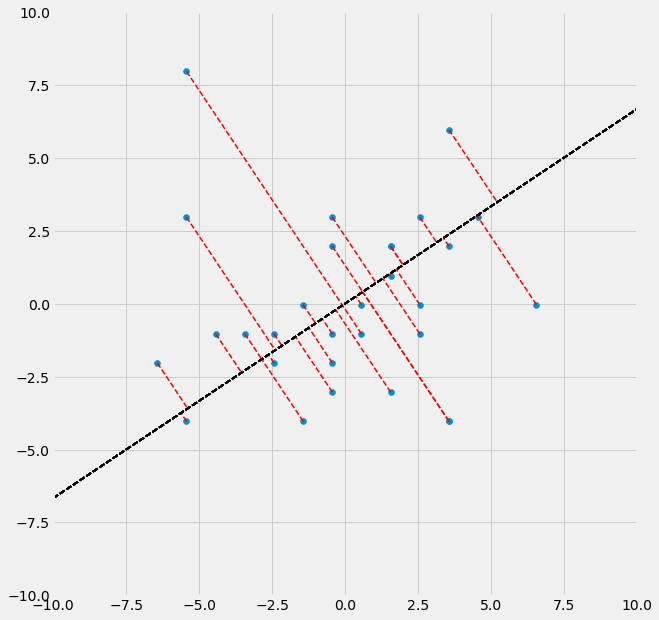

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler


# Normalize the input data
A = np.array([[10,8],[1,2],[7,5],[3,5],[7,6],[8,7],[9,9],[4,5],[6,5],[6,8],
             [1,9],[10,2],[6,3],[2,5],[1,14],[8,8],[9,5],[4,4],[5,6],[8,8],
             [11,9],[10,12],[6,4],[5,2],[10,2],[8,3],[6,9],[0,4],[13,6],[9,6]])

A = StandardScaler(with_std=False,copy=False).fit_transform(A)

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.set_aspect('equal')
ax0.set_xlim((-10,10))
ax0.set_ylim((-10,10))

ax0.scatter(A[:,0],A[:,1])


for i in range(len(A[:,0])):

    # v
    v = np.array([3,2])
    ax0.plot(np.linspace(-10,10),np.linspace(-10,10)*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5)   

    # w
    w = np.array([A[i][0],A[i][1]])
    #ax0.arrow(0,0,w[0],w[1],length_includes_head=True,width=0.01,color='green')

    # cv
    cv = (np.dot(w,v))/np.dot(v,np.transpose(v))*v
    #ax0.arrow(0,0,cv[0],cv[1],length_includes_head=True,width=0.005,color='black')
#    print(cv)

    # линия между v и cv
    ax0.plot([w[0],cv[0]],[w[1],cv[1]],'r--',linewidth=1.5)


    # проверить результат
#    print(np.dot((w-cv),cv))

plt.show()

# Условная вероятность 

Допустим, дана таблица

In [6]:
df = pd.DataFrame({'A':['foo', 'bar', 'foo', 'bar','foo', 'bar', 'foo', 'foo'], 'B':['one', 'one', 'two', 'three','two', 'two', 'one', 'three'], 'C':np.random.randn(8), 'D':np.random.randn(8)})
df

,A,B,C,D
0,foo,one,-1.077342,0.958669
1,bar,one,-0.625116,-1.069533
2,foo,two,1.244292,-0.367219
3,bar,three,1.473786,1.015292
4,foo,two,0.137060,0.985115
5,bar,two,-0.486579,-0.201135
6,foo,one,0.672037,0.133413
7,foo,three,-0.282648,1.231675


Предположим, что нам интересно рассчитать вероятность (y = foo), если x = один: P (y = foo | x = one) =?

Подход 1:
Series.value_counts() - возвращает количество уникальных элементов
count() - количество элементов
groupby() - группируем по значению столбца

In [8]:
df.groupby('B')['A'].value_counts()/df.groupby('B')['A'].count()

B      A  
one    foo    0.666667
       bar    0.333333
three  bar    0.500000
       foo    0.500000
two    foo    0.666667
       bar    0.333333
Name: A, dtype: float64

Итак, ответ: 0.6667

# Линейная регрессия для датасета "Цены на бостонские дома"

In [11]:
url='http://yustiks.ru/housing.csv'
s=requests.get(url).content
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data=pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, names=names)
print(data[:4])

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  


Основные значения:

* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* INDUS: This is the proportion of non-retail business acres per town.
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per 10,000 dollars
* PTRATIO: This is the pupil-teacher ratio by town
* B: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population
* MEDV: This is the median value of owner-occupied homes in 1000 dollars

Типы даннных

In [13]:
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Посмотрим стандартные характеристики распределение (медиана, мода, минимальное значение, максимальное)

In [14]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


**Максимальное значение переменной MEDV = 50. **

Посмотрим выбросы в данных с помощью boxplot

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


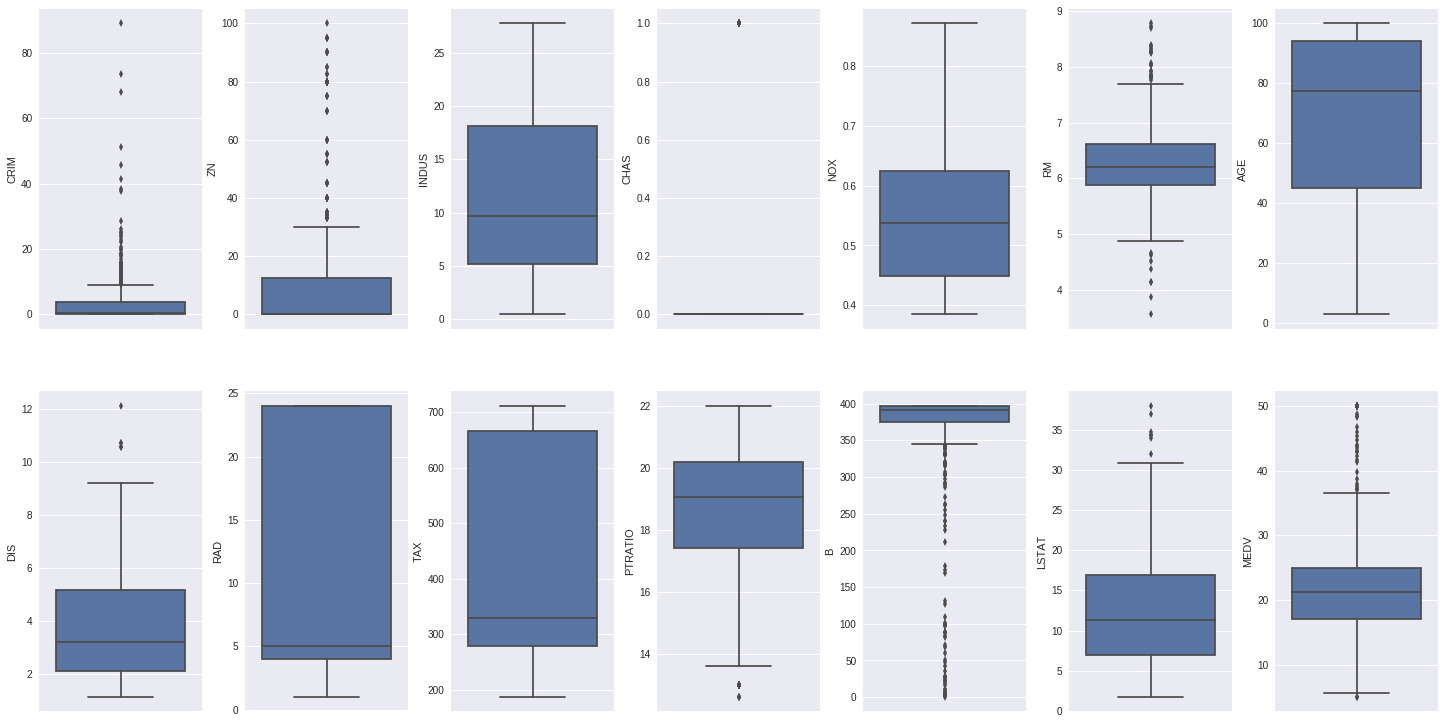

In [26]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Можно заметить, что такие значения как CRIM, ZN, RM, B имеют выбросы. 

Посмотрим процент выбросов в данных

In [28]:
    for k, v in data.items():
    # считаем точки в квантиле 25% от медианы
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        # выбросы находятся за этими точками
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Выбросы колнки %s = %.2f%%" % (k, perc))
    

Выбросы колнки CRIM = 13.04%
Выбросы колнки ZN = 13.44%
Выбросы колнки INDUS = 0.00%
Выбросы колнки CHAS = 100.00%
Выбросы колнки NOX = 0.00%
Выбросы колнки RM = 5.93%
Выбросы колнки AGE = 0.00%
Выбросы колнки DIS = 0.99%
Выбросы колнки RAD = 0.00%
Выбросы колнки TAX = 0.00%
Выбросы колнки PTRATIO = 2.96%
Выбросы колнки B = 15.22%
Выбросы колнки LSTAT = 1.38%
Выбросы колнки MEDV = 7.91%


Так как максимальное значение переменной MEDV = 50, удалим данные, не влияющие на предсказание цен выше 50

In [29]:
print(np.shape(data))
data = data[~(data['MEDV'] >= 50.0)]
print(np.shape(data))

(506, 14)
(490, 14)


Посмотрим плотности распределения значений

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


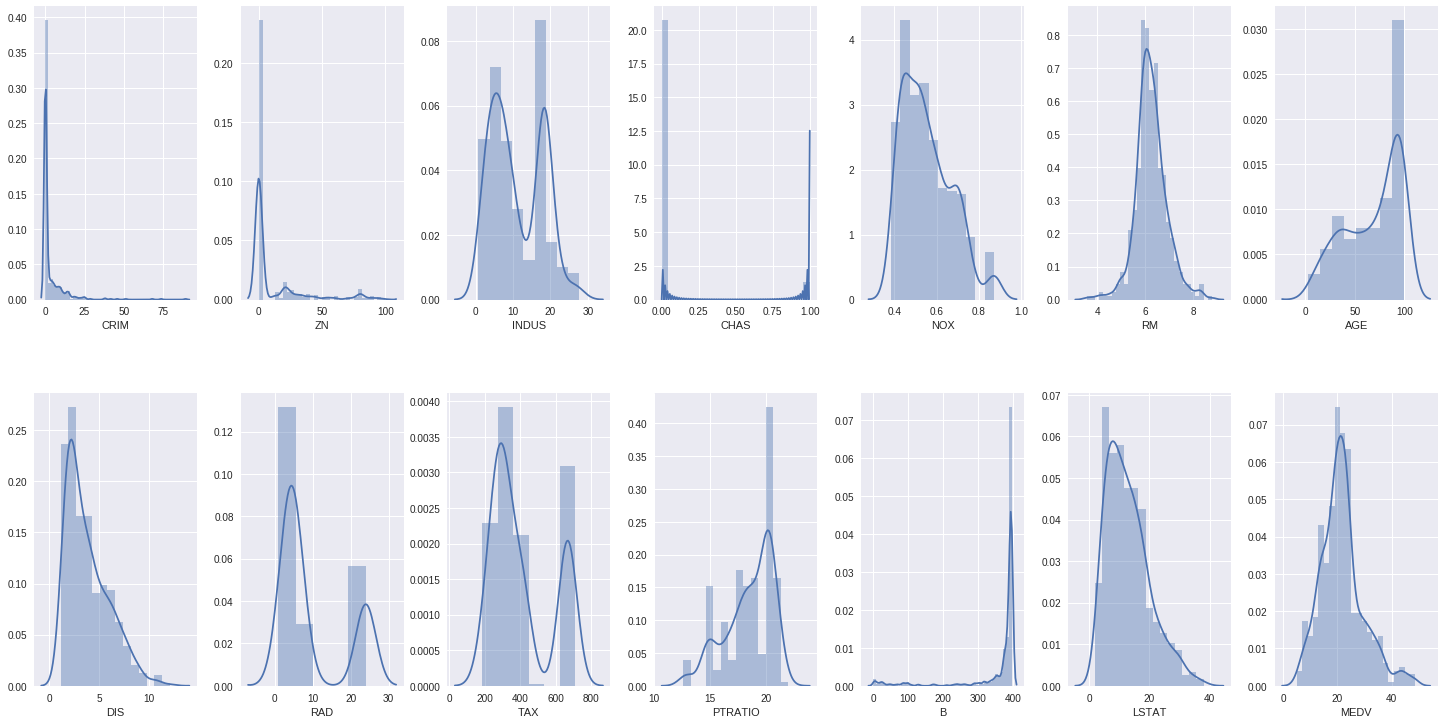

In [30]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Такие переменные, как CRIM, ZN, B имеют перекошенное распределение. MEDV похоже на нормальное распределение. 
Другие переменные имеют либо нормальное либо биноминальное распределение, кроме CHAS (дискретная переменная).

Построим график плотности распределения колонки 'MEDV'

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


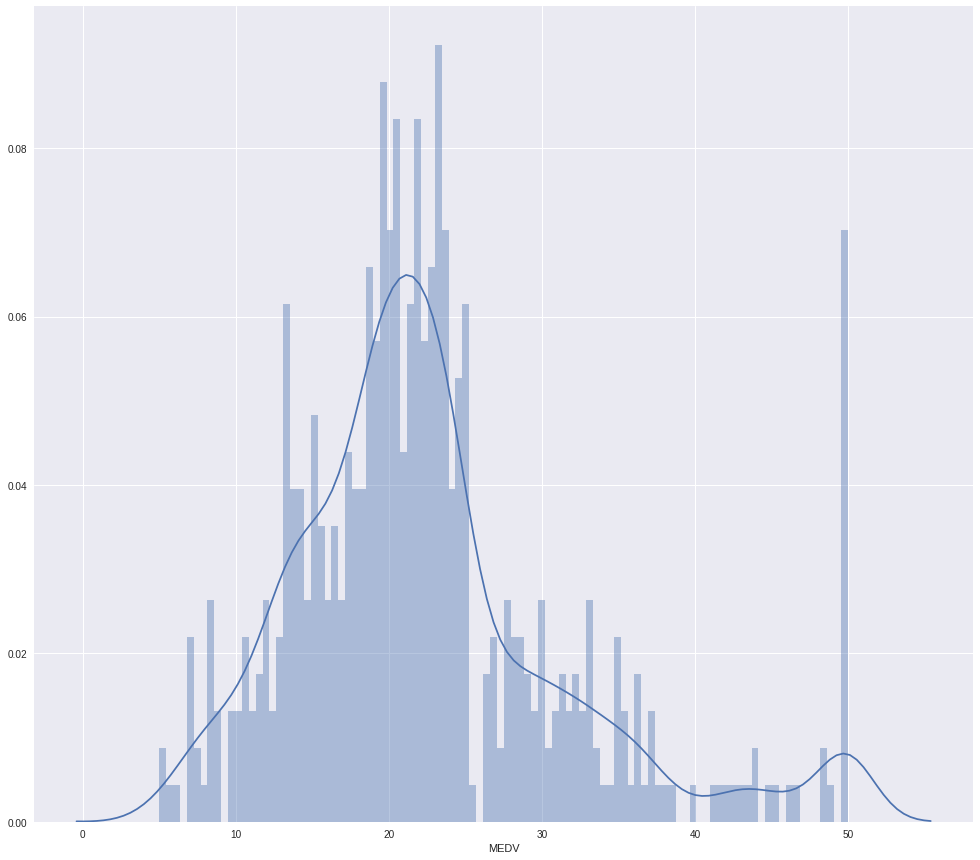

In [16]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(data['MEDV'], bins=100)
plt.show()

Можно заметить, что данные представляют собой нормальное распределение с некоторыми выбросами 

Построим матрицу корелляций

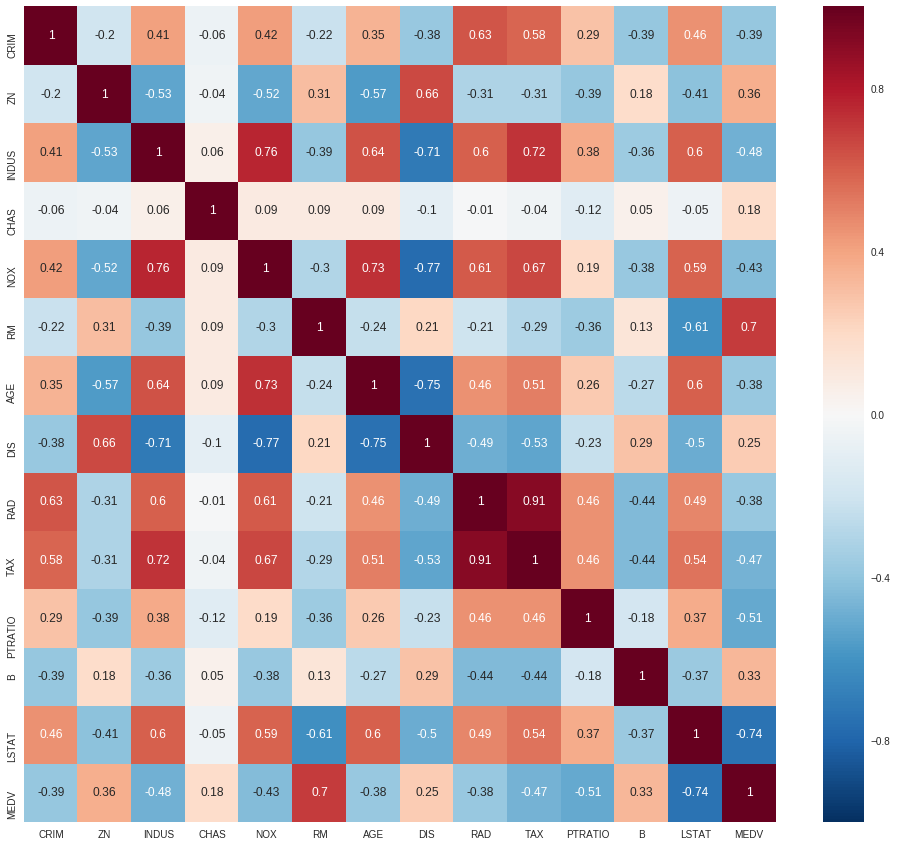

In [21]:
correlation_matrix = data.corr(method ='pearson').round(2)
# annot = True чтобы печатать значение внутри ячейки матрицы
sns.heatmap(data=correlation_matrix, annot=True)

In [23]:
print(sorted(correlation_matrix['MEDV']))

[-0.74, -0.51, -0.48, -0.47, -0.43, -0.39, -0.38, -0.38, 0.18, 0.25, 0.33, 0.36, 0.7, 1.0]


Наша задача - предсказать значение MEDV - средняя цена дома. Чтобы понять, какие переменные влияют на цену дома, посмотрим на корелляцию с данным значением. По сути, нам из таблицы нужны только те переменные, которые кореллируют (положительно или отрицательно) с искомым значением (MEDV). Можно увидеть, что RM имеет положительно высокую корелляцию с MEDV 0.7, вторая величина по корелляции - LTSAT (-0.74). 


*   Надо также проверять переменные на мультиколлинеарность: не стоит выбирать в качестве данных значения с высокой корелляцией. Например, следующими по величине абсолютной корелляции идут значения PTRATIO, INDUS, TAX. Мы можем их всех выбрать в качестве значимых данных, но TAX и INDUS между собой имеют корелляцию 72%, поэтому имеет смысл выбрать одну из них.  


Построим корелляцию  LSTAT, INDUS, RM, TAX, NOX, PTRAIO с MEDV, так как их абсолютное значение корелляции с MEDV более 50%

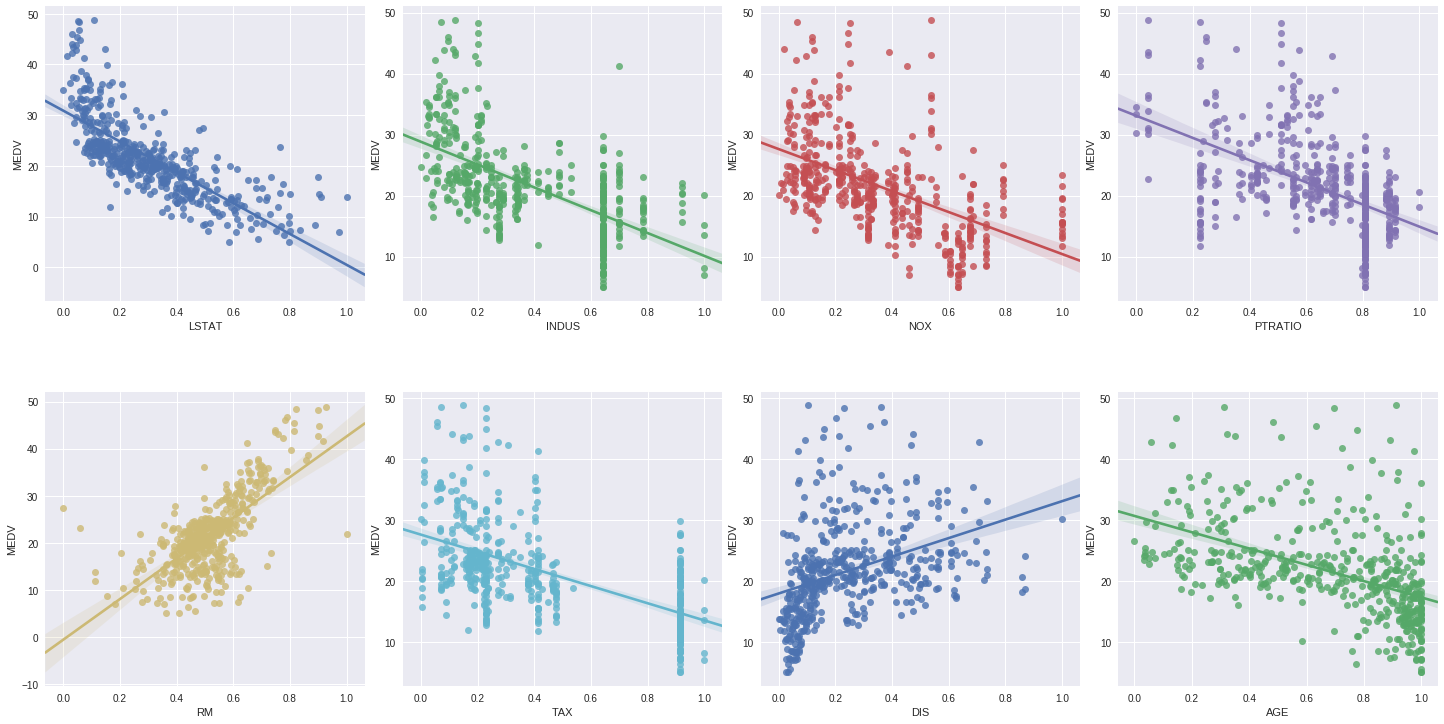

In [31]:
from sklearn import preprocessing
# нормализуем значения перед отрисовкой MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Наблюдения:

*   Линейная зависимость от переменной RM. Есть выбросы
*   Цена уменьшается, если увеличивается значение LSTAT. 
*   Цена увеличивается, если увеличивается RAD, особенно хорошо заметно в среднем значении, но не линейная зависимость, есть выбросы
*   Цена увеличивается, если увеличивается TAX, нелинейная зависимость, есть выбросы



Подводя итоги, мы можем выбрать для предсказания переменной MEDV такие значения, как 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE'. 

Перекошенность данных можно убрать с помощью логарифмических преобразований

In [0]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])